**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for personal scientific use. The crib sheet (or elements of the crib sheet) must not be ingested into third party libraries without written consent of the UCalgary team. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Multiple Imagers on the Same Mosaic**
---

### **Datasets**
All data from UCalgary ground-based geospace remote sensinhg projects can be found at https://data.phys.ucalgary.ca/. This crib sheet currently pertains to
- THEMIS ASI
- REGO
- TREx RGB
- TREx NIR
- NORSTAR NASCAM
- *TREx Blueline - Skymaps Coming Soon*
- *SMILE ASI - Coming Soon*
- *Rainbow ASI - Coming Soon*

</br>

### **Crib Sheet Summary**
The code and supporting documentation in this provides an example of mapping a collection of THEMIS, REGO and TREx RGB images onto a map.



</br>

---

</br>


## **Setup**

Install required dependencies using pip

In [ ]:
!pip install trex-imager-readfile themis-imager-readfile rego-imager-readfile aacgmv2 cartopy pyproj matplotlib scipy requests joblib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 50.8 MB/s eta 0:00:00
  Created wheel for aacgmv2: filename=aacgmv2-2.6.3-cp310-cp310-linux_x86_64.whl size=1679866 sha256=95561451a9379239e5d62cee56b90639e3f5bb41303373f39c98ec63f769d966
  Stored in directory: /root/.cache/pip/wheels/e9/d6/3f/10a359ebb903b2dbe5aa94f7024b5284059bb0daef65a7a0b4
Successfully built aacgmv2


In [ ]:
# import the necessary packages
import os
import glob
import datetime as dt
import pprint
import trex_imager_readfile
import themis_imager_readfile
import rego_imager_readfile
import aacgmv2
import cv2
import cartopy
import pyproj
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import requests
import joblib
from tqdm.notebook import tqdm

## **Downloading Data**

We need to download the data we're going to be using. UCalgary provides an API to help with this, and will be working further to make this process easier. You can learn more about how to use the API to download data by checking out the crib sheet for it on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible.

In [ ]:
# set the top-level output path we want to save the files to
#
# NOTE: This crib sheet assumes you're using Google Colab. Change as needed.
download_root_path = "/content/ucalgary_data"

In [ ]:
# These functions are helpers for downloading data, we won't go into any detail
# here, but just use them later on. Learn more by checking out the 'Downloading data
# from the API' crib sheet on data.phys.ucalgary.ca.

def download_url(url, prefix, output_base_path, overwrite=False, pbar=None):
    # set output filename
    output_filename = "%s/%s" % (output_base_path, url.removeprefix(prefix))
    if (overwrite is False and os.path.exists(output_filename)):
        if (pbar is not None):
            pbar.update()
        return

    # create destination directory
    try:
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    except Exception:
        # NOTE: sometimes when making directories in parallel there are race conditions. We put
        # in a catch here and carry on if there are ever issues.
        pass

    # retrieve file and save to disk
    r = requests.get(url)
    with open(output_filename, 'wb') as fp:
        fp.write(r.content)

    # advance progress bar
    if (pbar is not None):
        pbar.update()

def download_urls(dataset, urls, output_base_path, n_parallel=5, overwrite=False):
    prefix_to_strip = dataset["data_tree_url"]
    with tqdm(total=len(urls), desc="Downloading and saving files to disk") as pbar:
        joblib.Parallel(n_jobs=n_parallel, prefer="threads")(
            joblib.delayed(download_url)(
                urls[i],
                prefix_to_strip,
                os.path.join(output_base_path, dataset["name"]),
                overwrite=overwrite,
                pbar=pbar,
            ) for i in range(0, len(urls))
        )

def get_data_urls(dataset_name, start, end, site_uid=None):
    if (site_uid is None):
        params = {"name": dataset_name, "start": start, "end": end, "include_total_bytes": True}
    else:
        params = {"name": dataset_name, "start": start, "end": end, "site_uid": site_uid, "include_total_bytes": True}
    r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/urls", params=params)
    data = r.json()
    return data

def list_datasets(name=None):
    if (name is not None):
        params = {"name": name}
        r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/datasets", params=params)
    else:
        r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/datasets")
    datasets = r.json()
    return datasets

In [ ]:
# download 1 minute of TREx RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start = "2023-02-24T06:15"
end = "2023-02-24T06:15"
dataset = list_datasets(name=dataset_name)[0]
for site_uid in ['atha', 'gill', 'luck', 'rabb', 'yknf']:
    urls = get_data_urls(dataset_name, start, end, site_uid)["urls"]
    download_urls(dataset, urls, download_root_path)

# download 1 minute of THEMIS data from several sites
dataset_name = "THEMIS_ASI_RAW"
start = "2023-02-24T06:15"
end = "2023-02-24T06:15"
dataset = list_datasets(name=dataset_name)[0]
for site_uid in ['atha', 'fsmi']:
    urls = get_data_urls(dataset_name, start, end, site_uid)["urls"]
    download_urls(dataset, urls, download_root_path)

# download 1 minute of REGO data from one sites
dataset_name = "REGO_RAW"
start = "2023-02-24T06:15"
end = "2023-02-24T06:15"
dataset = list_datasets(name=dataset_name)[0]
for site_uid in ['rank']:
    urls = get_data_urls(dataset_name, start, end, site_uid)["urls"]
    download_urls(dataset, urls, download_root_path)

# download TREx RGB skymaps
urls = [
    'https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/atha/atha_20230115/rgb_skymap_atha_20230115-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/gill/gill_20221102/rgb_skymap_gill_20221102-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/luck/luck_20220406/rgb_skymap_luck_20220406-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/rabb/rabb_20220301/rgb_skymap_rabb_20220301-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps/yknf/yknf_20230114/rgb_skymap_yknf_20230114-+_v01.sav',
]
prefix = "https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/skymaps"  # this is used for saving the files to the place we want
for url in tqdm(urls, desc="Downloading and saving files to disk"):
  download_url(url, prefix, os.path.join(download_root_path, "skymap", "rgb"), pbar=None)

# download THEMIS skymaps
urls = [
    'https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/atha/atha_20230115/themis_skymap_atha_20230115-+_v02.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/fsmi/fsmi_20230321/themis_skymap_fsmi_20230321-+_v02.sav',
]
prefix = "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps"  # this is used for saving the files to the place we want
for url in tqdm(urls, desc="Downloading and saving files to disk"):
  download_url(url, prefix, os.path.join(download_root_path, "skymap", "themis"), pbar=None)

# download REGO skymaps
urls = [
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap/rank/rank_20221214/rego_skymap_rank_20221214-+_v01.sav',
]
prefix = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap"  # this is used for saving the files to the place we want
for url in tqdm(urls, desc="Downloading and saving files to disk"):
  download_url(url, prefix, os.path.join(download_root_path, "skymap", "rego"), pbar=None)

## **Creating a Multi-Imager Mosaic**

In [ ]:
# Defining our function to scale images.
def scale_image(data, cmin=0, cmax=65535, low=0, high=65535):
    if high > 65535:
        raise ValueError("`high` should be less than or equal to 65535.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    else:
        cmin = float(cmin)
    if cmax is None:
        cmax = data.max()
    else:
        cmax = float(cmax)

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint16)

In [ ]:
# This function can be used to read a skymap (IDL .sav file) into
# a Python dictionary for use.
def restore_skymap(skymap_f_path):

    # First returns a numpy record array
    skymap_obj = scipy.io.readsav(skymap_f_path)['skymap']
    skymap_keys = skymap_obj.dtype.names

    # Iterating through keys of record array
    skymap_dict = {}
    for key in skymap_keys:

        # Obtain the value of this skymap key
        iter_skymap_obj = skymap_obj[key][0]

        # If value is a bytestring, decode it
        if type(iter_skymap_obj) == bytes:
            iter_skymap_obj = iter_skymap_obj.decode("utf-8")

        # If value is another record array, convert it to dict
        if type(iter_skymap_obj) == np.recarray:
            recarray_to_dict = dict()
            for record_name in iter_skymap_obj.dtype.names:
                val = iter_skymap_obj[record_name][0]
                if type(val) == bytes:
                    val = val.decode("utf-8")
                recarray_to_dict[record_name] = val

            iter_skymap_obj = recarray_to_dict

        # Insert the obtained/converted value into the skymap dict
        skymap_dict[key] = iter_skymap_obj

    return(skymap_dict)

In [ ]:
# This function will take a list of skymap paths, and flatten them into
# a new format of skymaps, that can be used in plotting multiple images
# on a map, masking the boundaries between images by elevation angle.
# The function takes a height arguement, and interpolation is performed
# on the skymap to compute the coordinates for a given assumed auroral
# altitude.
def flatten_skymaps_multi_imager(skymap_filename_list, imager_id_list, site_id_list, height_km_list):

    # We need to seperate skymaps by dictionary keys, as different
    # images may have different sizes
    flattened_skymap = {}
    for site_idx, imager_id in enumerate(tqdm(imager_id_list, desc="Flattening Skymaps")):

        # Get the site name and assumed altitude for this iteration
        site_id = site_id_list[site_idx]
        height_km = height_km_list[site_idx]

        # Define the dimensions of this iteration's data
        if imager_id == 'rgb':
            height, width = (480, 553)
        if imager_id == 'themis':
            height, width = (256, 256)
        if imager_id == 'rego':
            height, width = (512, 512)

        # Define empty numpy arrays for the lats, lons, and elevation
        # angles of all of the sites. Also define numpy arrays for
        # 'filling' the pixel coordinates, which will contain polygon
        # vertices in lat/lon.
        lats = np.zeros((3, height+1, width+1))
        lons = np.zeros((3, height+1, width+1))
        elevation = np.zeros((width*height))
        polyfill_lat = np.zeros((width*height, 4))
        polyfill_lon = np.zeros((width*height, 4))
        site_lonlat = np.zeros((2))

        # Restore the skymap into a Python dict
        skymap_path = skymap_filename_list[site_idx]
        skymap = restore_skymap(skymap_path)

        # Grab the necessary data from the skymap
        altitudes = skymap["FULL_MAP_ALTITUDE"]
        lats[:,:,:] = skymap["FULL_MAP_LATITUDE"]
        tmp_lons = np.array(skymap["FULL_MAP_LONGITUDE"])
        tmp_lons[np.where(tmp_lons > 180)] -= 360
        lons[:,:,:] = tmp_lons
        site_lonlat[0] = skymap["SITE_MAP_LONGITUDE"]
        site_lonlat[1] = skymap["SITE_MAP_LATITUDE"]
        elev = skymap["FULL_ELEVATION"]

        # Iterate through each image pixel
        for ii in range(0,height-1):
            for jj in range(0, width-1):

                # Grab the longitudes of the corners of this pixel, at all three
                # assumed altitudes included in the skymap, and then use interpolation
                # to obtain the pixel corner coordinates at the input height. Then
                # add this array of coordinates (polygon) to the filling array.
                lon1 = np.interp(height_km, altitudes, lons[:,ii,jj])
                lon2 = np.interp(height_km, altitudes, lons[:,ii,jj+1])
                lon3 = np.interp(height_km, altitudes, lons[:,ii+1,jj+1])
                lon4 = np.interp(height_km, altitudes, lons[:,ii+1,jj])
                polyfill_lon[jj*height+ii,:] = np.array([lon1, lon2, lon3, lon4])

                # Repeat the above for latitudes.
                lat1 = np.interp(height_km, altitudes, lats[:,ii,jj])
                lat2 = np.interp(height_km, altitudes, lats[:,ii,jj+1])
                lat3 = np.interp(height_km, altitudes, lats[:,ii+1,jj+1])
                lat4 = np.interp(height_km, altitudes, lats[:,ii+1,jj])
                polyfill_lat[jj*height+ii,:] = np.array([lat1, lat2, lat3, lat4])

                # Add the current pixel's elevation angle to it's corresponding
                # place in the elevation array.
                elevation[jj*height+ii] = elev[ii,jj]

        # Once all site's indices have been filled in, turn this flattened skymap as a dict.,
        # and then store that in the master skymap dictionary.
        site_flattened_skymap = {'site_id':site_id,
                                 'lons':lons,
                                 'lats':lats,
                                 'elevation':elevation,
                                 'polyfill_lon':polyfill_lon,
                                 'polyfill_lat':polyfill_lat,
                                 'site_lonlat':site_lonlat}
        flattened_skymap[site_id+'_'+imager_id] = site_flattened_skymap

    return(flattened_skymap)

In [ ]:
# This function will take a list of image files, and convert them into a format
# that is compatible with the flattened skymaps for plotting.
def load_image_data_multi_imager(image_filename_list, imager_id_list):

    # Again, the data size for each image may be different, so we
    # will use a dictionary to hold everything
    data = {}
    for site_idx, imager_id in enumerate(imager_id_list):

        # Obtain the dimensions of the this iteration's images, as
        # well as the imaging cadence (s/frame). From this compute the
        # number of images that are expected for one minute of data.
        if imager_id == 'rgb':
            height, width = (480, 553)
            n_channels = 3
            cadence = 3
        if imager_id == 'themis':
            width, height = (256, 256)
            n_channels = 1
            cadence = 3
        if imager_id == 'rego':
            width, height = (512, 512)
            n_channels = 1
            cadence = 3

        predicted_n_imgs = int(60 / cadence)

        # For each site, create an empty dictionary to hold the image data
        # as well as the timestmap data, formatted as arrays, whose shapes
        # correspond to the expected (max) number of frames for one minute.
        if n_channels != 1:
            site_data = {'images':np.zeros((height,width,n_channels,predicted_n_imgs)),
                        'time_stamp':np.empty((predicted_n_imgs), dtype=object)}
        else:
            site_data = {'images':np.zeros((height,width,predicted_n_imgs)),
                        'time_stamp':np.empty((predicted_n_imgs), dtype=object)}

        # Read in this site's data
        if imager_id == 'rgb':
            img, meta, problematic_files = trex_imager_readfile.read_rgb(image_filename_list[site_idx])
            site_id = meta[0]['site_unique_id']
        if imager_id == 'themis':
            img, meta, problematic_files = themis_imager_readfile.read(image_filename_list[site_idx])
            site_id = meta[0]['Site unique ID']
        if imager_id == 'rego':
            img, meta, problematic_files = rego_imager_readfile.read(image_filename_list[site_idx])
            site_id = meta[0]['Site unique ID']

        # Detemined how many frames are actually included in this image array
        if img.shape[-1] <= predicted_n_imgs:
            real_n_imgs = img.shape[-1]
        else:
            real_n_imgs = 1

        # Generate a list of time strings that correspond to the predicted
        # image frames for this instrument.
        predicted_ts_list = np.empty((predicted_n_imgs), dtype=object)
        for i in range(0,predicted_n_imgs):
            if imager_id == 'rgb':
                expected_timestamp = meta[0]["image_request_start_timestamp"][11:17]+f'{cadence*i:02d}'
            else:
                expected_timestamp = meta[0]["Image request start"][11:17]+f'{cadence*i:02d}'
            predicted_ts_list[i] = expected_timestamp

        # Iterate through each frame in the real image array, and obtain the
        # timestamp from the metadata.
        for j in range(0,real_n_imgs):

            # Obtain the index of the predicted timestamp array that this real
            # timestamp is a match with. This is done to avoid discrepancys when
            # an imager skips a frame, or say, begins imaging partway through a minute.
            if imager_id == 'rgb':
                real_ts = meta[j]["image_request_start_timestamp"][11:19]
            else:
                real_ts = meta[j]["Image request start"][11:19]
            ts_idx = np.where(predicted_ts_list == real_ts)

            if len(ts_idx) != 1:
                print("Predicted timestamps: ", predicted_ts_list)
                print("Actual timestamp: ", real_ts)
                raise Exception("Error in timestamp comparison. See above for info.")

            # Add the image data, and timestmap, to the their actual location in the full
            # arrays, according to where the predicted timestamps say it belongs
            site_data['time_stamp'][ts_idx[0][0]] = real_ts
            if imager_id == 'rgb':
                site_data['images'][:,:,:,ts_idx[0][0]] = img[:,:,:,j]
            else:
                site_data['images'][:,:,ts_idx[0][0]] = img[:,:,j]

        # Once all frames have been loaded, add this site's data to the master dictionary
        data[site_id+'_'+imager_id] = site_data

    return(data)

In [ ]:
# Now we can begin actually making the mosaic, using the previously defined functions.
# Let's mosaic some images from TREx RGB, THEMIS, and REGO
imager_id_list = ['themis', 'themis','rego','rgb','rgb','rgb','rgb']
site_list = ['atha','fsmi','rank','gill','luck','yknf', 'rabb']
height_km_list =[110, 110, 110, 230, 110, 110, 110, 110]

# Let's load in image data corresponding to the site_list, for our time of interest
image_f_list = [os.path.join(download_root_path, 'THEMIS_ASI_RAW', '2023', '02', '24', 'atha_themis02', 'ut06', '20230224_0615_atha_themis02_full.pgm.gz'),
                os.path.join(download_root_path, 'THEMIS_ASI_RAW', '2023', '02', '24', 'fsmi_themis10', 'ut06', '20230224_0615_fsmi_themis10_full.pgm.gz'),
                os.path.join(download_root_path, 'REGO_RAW', '2023', '02', '24', 'rank_rego-649', 'ut06', '20230224_0615_rank_rego-649_6300.pgm.gz'),
                # os.path.join(download_root_path, 'TREX_RGB_RAW_NOMINAL', '2023', '02', '24', 'atha_rgb-07', 'ut06', '20230224_0615_atha_rgb-07_full.h5'),
                os.path.join(download_root_path, 'TREX_RGB_RAW_NOMINAL', '2023', '02', '24', 'gill_rgb-04', 'ut06', '20230224_0615_gill_rgb-04_full.h5'),
                os.path.join(download_root_path, 'TREX_RGB_RAW_NOMINAL', '2023', '02', '24', 'luck_rgb-03', 'ut06', '20230224_0615_luck_rgb-03_full.h5'),
                os.path.join(download_root_path, 'TREX_RGB_RAW_NOMINAL', '2023', '02', '24', 'yknf_rgb-08', 'ut06', '20230224_0615_yknf_rgb-08_full.h5'),
                os.path.join(download_root_path, 'TREX_RGB_RAW_NOMINAL', '2023', '02', '24', 'rabb_rgb-06', 'ut06', '20230224_0615_rabb_rgb-06_full.h5')]

# Now, we need skymaps corresponding to each site that we are loading image data for. Let's
# load in the skymap files that were created most recently prior to the date of interest.
skymap_f_list = [os.path.join(download_root_path, 'skymap', 'themis', 'atha', 'atha_20230115', 'themis_skymap_atha_20230115-+_v02.sav'),
                 os.path.join(download_root_path, 'skymap', 'themis', 'fsmi', 'fsmi_20230321', 'themis_skymap_fsmi_20230321-+_v02.sav'),
                 os.path.join(download_root_path, 'skymap', 'rego', 'rank', 'rank_20221214', 'rego_skymap_rank_20221214-+_v01.sav'),
                #  os.path.join(download_root_path, 'skymap', 'rgb', 'atha', 'atha_20230115', 'rgb_skymap_atha_20230115-+_v01.sav'),
                 os.path.join(download_root_path, 'skymap', 'rgb', 'gill', 'gill_20221102', 'rgb_skymap_gill_20221102-+_v01.sav'),
                 os.path.join(download_root_path, 'skymap', 'rgb', 'luck', 'luck_20220406', 'rgb_skymap_luck_20220406-+_v01.sav'),
                 os.path.join(download_root_path, 'skymap', 'rgb', 'yknf', 'yknf_20230114', 'rgb_skymap_yknf_20230114-+_v01.sav'),
                 os.path.join(download_root_path, 'skymap', 'rgb', 'rabb', 'rabb_20220301', 'rgb_skymap_rabb_20220301-+_v01.sav')]

In [ ]:
# Next, let's use our previously defined functions to flatten the skymaps
# as well as the image data, so it is in a format to be plotted properly.
flattened_skymaps = flatten_skymaps_multi_imager(skymap_f_list, imager_id_list, site_list, height_km_list)
image_data = load_image_data_multi_imager(image_f_list, imager_id_list)

Flattening Skymaps:   0%|          | 0/7 [00:00<?, ?it/s]

Crunching numbers:   0%|          | 0/265440 [00:00<?, ?it/s]

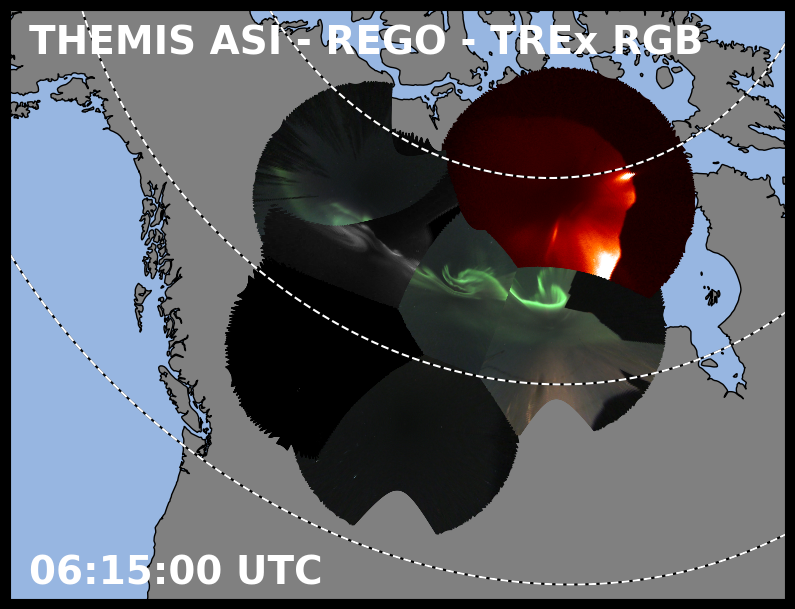

In [ ]:
# Define the minumum elevation angle that we would like to plot
# as well as the frame index.
elevation_threshold = 5
frame_idx = 0

# Now, before we begin plotting let's define some parameters about the map. We will
# use Cartopy to initialize the actual map projection and boundaries. See Cartopy's
# docs for info about other projections, we will use a satellite view here.
desired_projection = cartopy.crs.NearsidePerspective(central_longitude=-100, central_latitude=55, satellite_height=35785831)

# Initialize the plotting figure/axis
plt.figure(figsize=(10,10), facecolor='black')
ax = plt.axes(projection=desired_projection)
# ax.set_global() # <--- Plot the full globe
ax.set_extent([-135, -80, 40, 70])
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, facecolor='gray', edgecolor='black')

# Now, in order to convert from geodetic coordinates onto the map projection, we will
# use PyProj, as it is much more efficient in doing so than Cartopy. We can define
# a transformation object between geodetic coordinates and our desired projection:
pyproj_src_proj = pyproj.CRS.from_user_input(cartopy.crs.Geodetic())
pyproj_des_proj = pyproj.CRS.from_user_input(desired_projection)
transformer = pyproj.Transformer.from_crs(pyproj_src_proj, pyproj_des_proj, always_xy=True)

# First let's add some lines of constant geomagnetic latitude to the plot using the AACGM library

date_obj = dt.datetime(2023,2,24)

lat_line_dict = {}
lon_line_dict = {}

lat_range = np.arange(-90,90+0.1,0.1)
lon_range = np.arange(-180,180+0.2,0.2)

for iter_lat in [52,62,72]:

    const_lat_x, const_lat_y = (lon_range, lon_range*0+iter_lat)

    const_lat_y, const_lat_x, alt = aacgmv2.convert_latlon_arr(const_lat_y, const_lat_x, const_lat_x*0.0, date_obj, method_code='A2G')
    const_lat_x, const_lat_y = transformer.transform(const_lat_x, lon_range*0.+const_lat_y)

    ax.plot(const_lat_x, const_lat_y, color='black')
    ax.plot(const_lat_x, const_lat_y, color='white', linestyle='dashed')

# Define the number of elements in each dataset's image frame, and
max_dims = {'rgb':480*553, 'rego':512*512, 'themis':256*256}

# We need a numpy array of the sites requested, that will be used to make sure any sites
# that don't have data for the requested frame are not plotted. Then we will define three
# dictionaries: img_tmp will hold the image data of each site, sorted according to elevation
# angle, which is done using the other two arrays, elev and s.
site_imager_arr = np.array([site+'_'+imager for site, imager in zip(site_list, imager_id_list)])
img_tmp = {}
elev = {}
s = {}

# Now we begin to fill in the above arrays, one site at a time. Before doing so
# we need lists to keep track of which sites actually have data for this frame.
sites_imagers_with_data = []
sites_imagers_with_data_idx = []

# We also define a list that will hold all unique timetamps pulled from each
# frame's metadata. This should be of length 1, and we can check that to make
# sure all images being plotted correspond to the same time.
unique_timestamps = []
for site_idx, imager_id in enumerate(imager_id_list):

    site_id = site_list[site_idx]

    # Get the dimensions and scaling bounds for this iteration's data
    if imager_id == 'themis':
        height, width = (256, 256)
        scl_min, scl_max = (3500, 14000)
    if imager_id == 'rego':
        height, width = (512, 512)
        scl_min, scl_max = (250, 1500)
    if imager_id == 'nir':
        height, width = (256, 256)
        scl_min, scl_max = (1000, 16000)
    if imager_id == 'rgb':
        height, width = (480, 553)
        scl_min, scl_max = (0,120)
        n_channels = 3

    # Then we will define three numpy arrays: iter_img_tmp will hold the image data of this site, sorted
    # according to elevation angle, which is done using the other two arrays, iter_elev and iter_s.
    if imager_id == 'rgb':
        iter_img_tmp = np.zeros((width*height, n_channels), dtype=np.int32)
    else:
        iter_img_tmp = np.zeros((width*height), dtype=np.int32)
    iter_elev = np.zeros((width*height))
    iter_s = np.zeros((width*height), dtype=np.int32)

    meta_timestamp = image_data[site_id+'_'+imager_id]["time_stamp"][frame_idx]

    # Set the sorting array for the current iteration to the indices
    # that would sort the flattened elevation skymap. Then use this to
    # insert the sorted elevations into the elev array.
    iter_s = np.argsort(flattened_skymaps[site_id+'_'+imager_id]["elevation"])
    iter_elev = flattened_skymaps[site_id+'_'+imager_id]["elevation"][iter_s]

    # Obtain the acutal image data
    if imager_id == 'rgb':
        tmp1 = image_data[site_id+'_'+imager_id]["images"][:,:,:,frame_idx]
    else:
        tmp1 = image_data[site_id+'_'+imager_id]["images"][:,:,frame_idx]

    # If the sum of the image data is zero, then there is no data for this
    # site, so we skip it
    if np.sum(tmp1) == 0.0:
        continue

    # If there is data, first update our list for tracking which sites have data
    # as well as their indices.
    else:

        # Scale this site's data based on previously defined scaling bounds
        tmp1 = scale_image(tmp1, cmin = scl_min, cmax = scl_max, high=255)

        # Add the timestamp to tracking list if it's unique
        if meta_timestamp not in unique_timestamps:
            unique_timestamps.append(meta_timestamp)

        sites_imagers_with_data.append(site_id+'_'+imager_id)
        sites_imagers_with_data_idx.append(np.where(site_imager_arr == site_id+'_'+imager_id)[0][0])

        # Iterate through all the pixels in order of elevation and add them to the reformed data array
        if imager_id == 'rgb':
            for ii in range(0,height):
                for jj in range(0,width):

                    iter_img_tmp[jj*height+ii,:] = tmp1[ii,jj,:]
        else:
            for ii in range(0,height):
                for jj in range(0,width):
                    iter_img_tmp[jj*height+ii] = tmp1[ii,jj]

    # Update the master dictionaries with this iteration's data
    img_tmp[site_id+'_'+imager_id] = iter_img_tmp
    elev[site_id+'_'+imager_id] = iter_elev
    s[site_id+'_'+imager_id] = iter_s

# This checks to make sure all images have the same timestamps
if len(unique_timestamps) != 1:
    raise Exception("Error: Images have different timestamps.")

# Now that all of the image data has been sorted and stored properly
# we will iterate through and obtain all of the coordinate polygons
# that correspond to each pixel. We need two lists, to keep track of
# the coordinate vertices, as well as the rgb values of each pixel.
lon_list = []
lat_list = []
rgb_vals = []

# Notice, we iterate throught the number of elements in an RGB image
# because in this case, it is the largest array. In order to properly
# define the elevation boundaries between the different imagers, we will have
# to adjust the iteration variable within each loop, depending on the imager.
# We require iteration through the different sized imager arrays to occur at
# the same rate relative to eachother, so we can adjust the iteration idx for
# each loop by a factor of the ratio between the current iteration's image
# data size, and the largest (rgb in this case) data size:
themis_ratio_scale = max_dims['themis'] / max_dims['rgb']
rego_ratio_scale = max_dims['rego'] / max_dims['rgb']

for jj in tqdm(range(0,max_dims['rgb']), desc="Crunching numbers"):
    for site_imager, site_idx in zip(sites_imagers_with_data, sites_imagers_with_data_idx):

        site_id = site_list[site_idx]
        imager_id = imager_id_list[site_idx]

        # Scaling the iteration accordingly
        if imager_id == 'rgb':
            ii = jj
        if imager_id == 'themis':
            ii = round(jj*themis_ratio_scale)
        if imager_id == 'rego':
            ii = round(jj*rego_ratio_scale)

        # If the iteration ever ends up being bigger than the max dimensions we skip it
        if ii >= max_dims[imager_id]:
            continue

        # Obtain the lats and lons of the pixel corners from the skymap
        lons = flattened_skymaps[site_imager]["polyfill_lon"][s[site_imager][ii],:]
        lats = flattened_skymaps[site_imager]["polyfill_lat"][s[site_imager][ii],:]

         # Only proceed if this pixel has 4 non-NaN corner coordinates, and is
        # above the elevation threshold we are interested in plotting
        if elev[site_imager][ii] < elevation_threshold:
            continue
        if len(lons[~ np.isnan(lons)]) != 4:
            continue
        if len(lats[~ np.isnan(lats)]) != 4:
            continue

        # Append lats and lons of vertices to lists
        lon_list.append(lons)
        lat_list.append(lats)

        # Depending on the number of image channels, convert either this pixel's rgb
        # value to floats, or it's indexed value into a colortable to a rgb float
        if imager_id == 'rgb':
            pixel_rgb = img_tmp[site_imager][s[site_imager][ii],:] / 255.0
        if imager_id == 'themis':
            pixel_rgb = matplotlib.cm.gray(float(img_tmp[site_imager][s[site_imager][ii]]) / 255.)
        if imager_id == 'rego':
            pixel_rgb = matplotlib.cm.gist_heat(float(img_tmp[site_imager][s[site_imager][ii]]) / 255.)
        if imager_id == 'nir':
            pixel_rgb = matplotlib.cm.autumn(float(img_tmp[site_imager][s[site_imager][ii]]) / 255.)

        rgb_vals.append(pixel_rgb)

# Use our transformer object to convert the lat/lon polygons into projection coordinates.
lons, lats = transformer.transform(np.array(lon_list), np.array(lat_list))
lonlat_polygons = np.empty((lons.shape[0],4,2))
lonlat_polygons[:,:,0] = lons
lonlat_polygons[:,:,1] = lats

# Generate a PolyCollection object, containing all of the Polygons shaded with their corresponding RGB value
img_data_poly = matplotlib.collections.PolyCollection(lonlat_polygons, array=None, facecolors=rgb_vals, edgecolors='face')

# Finally, we can add the PolyCollection object to our plotting axis, and display
ax.add_collection(img_data_poly)
plt.text(0.025, 0.925, 'THEMIS ASI - REGO - TREx RGB', color='white', fontsize=28, transform=ax.transAxes, weight='bold')
plt.text(0.025, 0.025, meta_timestamp+' UTC', color='white', fontsize=28, transform=ax.transAxes, weight='bold')
plt.show()

Note: In practice, it is not really useful to mask between REGO and THEMIS/RGB - due to REGO's narrow band nature, the imagers are not looking at the same thing - but it is just done here as an example.